# Inzichten in verkeersongevallen met gewonden in Belgie, gekoppeld aan het inwonersaantal van gemeenten

## Over deze notebook
In deze notebook gaan wij, Laurens Hens en Furkan Yasar, opzoek naar inzichten in het aantal verkeersongevallen met gewonden in België. We proberen ook het aantal ongevallen te koppelen aan het inwonersaantal van gemeenten om te kijken of er verbanden bestaan.

De gebruikte datasets zijn terug te vinden op de website van [The Belgian Open Data Initiative](https://data.gov.be/). Concreet [Verkeersongevallen](https://data.gov.be/en/search/site/Verkeersongevallen) en [Bevolking](https://data.gov.be/en/search/site/Bevolking%2520naar%2520woonplaats%252C%2520nationaliteit%252C%2520burgerlijke%2520staat) voor de jaren 2016 tot en met 2020. De bronbestanden werden gedownload in XLSX formaat, geopend in Microsoft Excel en terug opgeslagen in CSV UTF-8 formaat om de import in deze Notebook gemakkelijker te maken.

Voor onze visualisaties op de Folium map hadden we ook nood aan coordinaten data van alle gemeenten. Hiervoor hebben we nog een bijkomende dataset gevonden op [Gemeente Zoeker](http://www.gemeentezoeker.be/developer.php).

## Setup
Om onze notebook correct uit te voeren, komen er wat imports van packages en setup aan te pas. De packages die we gebruiken zijn pyspark, matplotlib, ipywidgets, numpy en folium.

In [1]:
# SETUP

import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable


import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType 
from pyspark.sql.types import ArrayType, DoubleType, BooleanType
from pyspark.sql.functions import col,array_contains,when,lit
import pyspark.sql.functions as sf

from functools import reduce
from pyspark.sql import DataFrame

import ipywidgets as widgets

from matplotlib import pyplot as plt

import numpy as np

import folium

from IPython.display import display

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

spark = SparkSession.builder.appName('test').getOrCreate()
sc = spark.sparkContext

## Data import
Als volgende stap gaan we onze bronbestanden importeren. Ze worden rechtstreeks geimporteerd als Spark Dataframes.

In [2]:
# IMPORT RAW DATA

# Import accident data
df_raw_acc_2016 = spark.read.format("csv") \
    .option("header", True) \
    .load('./data/TF_ACCIDENTS_2016.csv')

df_raw_acc_2017 = spark.read.format("csv") \
    .option("header", True) \
    .load('./data/TF_ACCIDENTS_2017.csv')

df_raw_acc_2018 = spark.read.format("csv") \
    .option("header", True) \
    .load('./data/TF_ACCIDENTS_2018.csv')

df_raw_acc_2019 = spark.read.format("csv") \
    .option("header", True) \
    .load('./data/TF_ACCIDENTS_2019.csv')

df_raw_acc_2020 = spark.read.format("csv") \
    .option("header", True) \
    .load('./data/TF_ACCIDENTS_2020.csv')


# Import inhabitant data
df_raw_inh_2016 = spark.read.format("csv") \
    .option("header", True) \
    .load('./data/TF_SOC_POP_STRUCT_2016.csv')

df_raw_inh_2017 = spark.read.format("csv") \
    .option("header", True) \
    .load('./data/TF_SOC_POP_STRUCT_2017.csv')

df_raw_inh_2018 = spark.read.format("csv") \
    .option("header", True) \
    .load('./data/TF_SOC_POP_STRUCT_2018.csv')

df_raw_inh_2019 = spark.read.format("csv") \
    .option("header", True) \
    .load('./data/TF_SOC_POP_STRUCT_2019.csv')

df_raw_inh_2020 = spark.read.format("csv") \
    .option("header", True) \
    .load('./data/TF_SOC_POP_STRUCT_2020.csv')


# Import muncipality coordinate data
df_coords = spark.read.format("csv") \
    .option("delimiter", ";") \
    .option("encoding", "UTF-8") \
    .load('./data/POSTCODE_COORDS.csv')

## Data manipulatie
De logische volgende stap nu we de bronbestanden hebben ingeladen is die van de data manipulatie, waar we concreet alle dataframes gaan samenvoegen, opkuisen waar nodig en verder gaan manipuleren.

**Inwonersaantal gemeenten - processing** <br />
Niet alle bronbestanden bevatten een kolom met daarin het jaar waartoe de inwonersaantallen behoren. We voegen deze toe aan de dataframes. 

Hierna voegen we alle dataframes samen tot één grote dataframe. 

We vangen ook nog een kleine spellingsverandering van de gemeente Blégny op.

Vervolgens groeperen we in dit grote dataframe per jaar en gemeente, zodat we een totale som van inwonersaantallen krijgen voor iedere gemeente, per jaar.

In [3]:
# MUNCIPALITY INHABITANT DATA PROCESSING

# Add year to data
df_raw_inh_2016 = df_raw_inh_2016.withColumn('CD_YEAR', lit(2016))
df_raw_inh_2017 = df_raw_inh_2017.withColumn('CD_YEAR', lit(2017))
df_raw_inh_2018 = df_raw_inh_2018.withColumn('CD_YEAR', lit(2018))
df_raw_inh_2019 = df_raw_inh_2019.withColumn('CD_YEAR', lit(2019))
df_raw_inh_2020 = df_raw_inh_2020.withColumn('CD_YEAR', lit(2020))


df_all_inh = reduce(DataFrame.unionAll, [df_raw_inh_2016,df_raw_inh_2017,df_raw_inh_2018,df_raw_inh_2019,df_raw_inh_2020])

# Renaming muncipalities
df_all_inh = df_all_inh.withColumn("TX_MUNTY_DESCR_NL", when(df_all_inh.TX_MUNTY_DESCR_NL == "Blegny","Blégny").otherwise(df_all_inh.TX_MUNTY_DESCR_NL))

# df_all_inh.withColumn('MS_POPULATION', df_all_inh['MS_POPULATION'].cast(IntegerType())).groupBy('TX_MUNTY_DESCR_NL', 'CD_YEAR').agg(sf.sum('MS_POPULATION').alias('INHABITANTS')).filter(df_all_inh.TX_MUNTY_DESCR_NL == 'Blégny').show(vertical=True)

df_all_inh_year = df_all_inh.withColumn('MS_POPULATION', df_all_inh['MS_POPULATION'].cast(IntegerType())).groupBy('TX_MUNTY_DESCR_NL', 'CD_YEAR').agg(sf.sum('MS_POPULATION').alias('INHABITANTS'))

#df_all_inh_year.filter(df_all_inh_year.TX_MUNTY_DESCR_NL == 'Bever').show(vertical=True)

**Coordinaten gemeenten - processing** </br>
De originele dataset bevat meerdere kolommen die we niet nodig hebben. Ook zijn er geen kolomnamen meegegeven in de dataset, dus deze voegen we ook toe.

Verder zijn er heel wat gemeenten die in hun Franse spelling staan. We zetten deze om naar de Nederlandse spelling. Verder volgen sommige gemeente ook een andere benaming dan in onze Verkeersongevallen en Inwonersaantal datasets. We passen de benaming hieraan aan.

De dataset ontbreekt ook wat coordinaten voor redelijk recent gefuseerde gemeenten. Hiervoor maken we een nieuw dataframe aan, die we uiteindelijk samenvoegen met de andere coordinaten data.

Tenslotte bevat het samengevoegde dataframe enkele dubbele rijen voor welbepaalde gemeentenamen, we behouden enkel de eerste rij die we tegenkomen.

In [4]:
# MUNCIPALITY COORDINATE DATA PROCESSING

# Only keep needed columns, rename columns
df2 = df_coords.select('_c1', '_c2', '_c3') \
.withColumnRenamed('_c1', 'Gemeente') \
.withColumnRenamed('_c2', 'XCoord') \
.withColumnRenamed('_c3', 'YCoord')


# Rename muncipalities (French -> Dutch, other conversions...)
df3 = df2.withColumn("Gemeente", when(df2.Gemeente == "Arlon","Aarlen") \
                     .when(df2.Gemeente == "Aalst", "Aalst (Aalst)")
                     .when(df2.Gemeente == "Ath","Aat") \
                     .when(df2.Gemeente == "Baelen (Lg.)","Baelen") \
                     .when(df2.Gemeente == "Bastogne","Bastenaken") \
                     .when(df2.Gemeente == "Mons","Bergen") \
                     .when(df2.Gemeente == "Beauvechain","Bevekom") \
                     .when(df2.Gemeente == "Beveren-Waas","Beveren (Sint-Niklaas)") \
                     .when(df2.Gemeente == "Bassenge","Bitsingen") \
                     .when(df2.Gemeente == "Bievre","Bièvre") \
                     .when(df2.Gemeente == "Waremme","Borgworm") \
                     .when(df2.Gemeente == "Borsbeek (Antw.)","Borsbeek") \
                     .when(df2.Gemeente == "Celles (Ht.)","Celles (Doornik)") \
                     .when(df2.Gemeente == "Tournai","Doornik") \
                     .when(df2.Gemeente == "Braine-l'Alleud","Eigenbrakel") \
                     .when(df2.Gemeente == "Ellezelles","Elzele") \
                     .when(df2.Gemeente == "Fontaine-l'Evêque","Fontaine-l’Evêque") \
                     .when(df2.Gemeente == "Jodoigne","Geldenaken") \
                     .when(df2.Gemeente == "Genappe","Genepiën") \
                     .when(df2.Gemeente == "Glabbeek-Zuurbemde","Glabbeek") \
                     .when(df2.Gemeente == "Grez-Doiceau","Graven") \
                     .when(df2.Gemeente == "Halle","Halle (Halle-Vilvoorde)") \
                     .when(df2.Gemeente == "Hamme (O.-Vl.)","Hamme (Dendermonde)") \
                     .when(df2.Gemeente == "Hannut","Hannuit") \
                     .when(df2.Gemeente == "Huy","Hoei") \
                     .when(df2.Gemeente == "Hove","Hove (Antwerpen)") \
                     .when(df2.Gemeente == "Ittre","Itter") \
                     .when(df2.Gemeente == "Jurbise","Jurbeke") \
                     .when(df2.Gemeente == "Kapellen (Antw.)", "Kapellen (Antwerpen)") \
                     .when(df2.Gemeente == "Braine-le-Château","Kasteelbrakel") \
                     .when(df2.Gemeente == "Lessines","Lessen") \
                     .when(df2.Gemeente == "Lincent","Lijsem") \
                     .when(df2.Gemeente == "Limbourg","Limburg") \
                     .when(df2.Gemeente == "Liège","Luik") \
                     .when(df2.Gemeente == "Machelen (Bt.)","Machelen (Halle-Vilvoorde)") \
                     .when(df2.Gemeente == "Meix-Devant-Virton","Meix-devant-Virton") \
                     .when(df2.Gemeente == "Moerbeke","Moerbeke (Gent)") \
                     .when(df2.Gemeente == "Mont-de-l'Enclus","Mont-de-l’Enclus") \
                     .when(df2.Gemeente == "Namur","Namen") \
                     .when(df2.Gemeente == "Neufchâteau","Neufchâteau (Neufchâteau)") \
                     .when(df2.Gemeente == "Nieuwerkerken (Limb.)","Nieuwerkerken (Hasselt)") \
                     .when(df2.Gemeente == "Nivelles","Nijvel") \
                     .when(df2.Gemeente == "Oreye","Oerle") \
                     .when(df2.Gemeente == "Silly","Opzullik") \
                     .when(df2.Gemeente == "Perwez","Perwijs (Nijvel)") \
                     .when(df2.Gemeente == "Saint-Léger (Lux.)","Saint-Léger (Virton)") \
                     .when(df2.Gemeente == "Saint-Nicolas (Lg.)","Saint-Nicolas (Luik)") \
                     .when(df2.Gemeente == "Sint-Niklaas","Sint-Niklaas (Sint-Niklaas)") \
                     .when(df2.Gemeente == "La Hulpe","Terhulpen") \
                     .when(df2.Gemeente == "Tielt","Tielt (Tielt)") \
                     .when(df2.Gemeente == "Tubize","Tubeke") \
                     .when(df2.Gemeente == "Vaux-sur-Sure","Vaux-sur-Sûre") \
                     .when(df2.Gemeente == "Villers-le-Bouillet","Villers-Le-Bouillet") \
                     .when(df2.Gemeente == "Vorst","Vorst (Brussel-Hoofdstad)") \
                     .when(df2.Gemeente == "Wavre","Waver") \
                     .when(df2.Gemeente == "Visé","Wezet") \
                     .when(df2.Gemeente == "Soignies","Zinnik") \
                     .when(df2.Gemeente == "Braine-le-Comte","’s Gravenbrakel") \
                     .otherwise(df2.Gemeente))

# Adding missing records of merged muncipalities
missing_coords_data = [('Kruisem', 50.90855, 3.56489),
                      ('Lievegem', 51.130353, 3.593253),
                      ('Oudsbergen',51.05, 5.6),
                      ('Pelt', 51.22889, 5.43167),
                      ('Puurs-Sint-Amands',51.055556, 4.253889)]
missing_coords_columns = ['Gemeente','XCoord','YCoord']

df_missing_coords = spark.createDataFrame(missing_coords_data, missing_coords_columns)

df_all_coords = df3.union(df_missing_coords)

# Removing duplicates
df_all_coords = df_all_coords.dropDuplicates(['Gemeente'])

**Verkeersongevallen gemeenten - processing** </br>
We voegen eerst alle dataframes samen tot één groot dataframe.

Ook hier vangen we de spellingsverandering van de gemeente Blégny op.

Verder gaan we uit de datum kolom het jaar, de maand en bijhorende maandnummer afsplisten in nieuwe kolommen zodat we er later groeperingen mee kunnen uitvoeren.

In de originele dataset geven ze vijf kolommen mee die het aantal slachtoffers in een bepaalde graad van ernst bevat (dodelijk, dodelijk binnen 30 dagen, verwondingen die leiden tot de dood, ernstig gewond en licht gewond). Het kan dat een ongeval meerdere slachtoffers heeft en dat er ook twee (of meer) types van slachtoffers voorkomen. Omdat wij visualisaties willen maken die het aantal ongevallen op basis van ernst gaan indelen, doen wij hier wat manipulatie op. Zo kan ieder ongeval maar een ernst hebben: we geven de meest ernstige prioriteit. Ook passen we alles aan naar ofwel 0 of 1 waarden.

In [5]:
# ACCIDENT DATA PROCESSING

# Union all accident dataframes
df_all_acc = reduce(DataFrame.unionAll, [df_raw_acc_2016, df_raw_acc_2017, df_raw_acc_2018, df_raw_acc_2019, df_raw_acc_2020])

# Renaming muncipalities
df_all_acc = df_all_acc.withColumn("TX_MUNTY_DESCR_NL", when(df_all_acc.TX_MUNTY_DESCR_NL == "Blegny","Blégny").otherwise(df_all_acc.TX_MUNTY_DESCR_NL))

# Seperating year from date
df_all_acc = df_all_acc.withColumn("YEAR", when(df_all_acc.DT_DAY.like('%-16'),'2016')
                                   .when(df_all_acc.DT_DAY.like('%-17'),'2017')
                                   .when(df_all_acc.DT_DAY.like('%-18'),'2018')
                                   .when(df_all_acc.DT_DAY.like('%-19'),'2019')
                                   .when(df_all_acc.DT_DAY.like('%-20'),'2020'))


# Seperating month from date
df_all_acc = df_all_acc.withColumn("MONTH", when(df_all_acc.DT_DAY.like('%Jan%'),'Januari')
                                   .when(df_all_acc.DT_DAY.like('%Feb%'),'Februari')
                                   .when(df_all_acc.DT_DAY.like('%Mar%'),'Maart')
                                   .when(df_all_acc.DT_DAY.like('%Apr%'),'April')
                                   .when(df_all_acc.DT_DAY.like('%May%'),'Mei')
                                   .when(df_all_acc.DT_DAY.like('%Jun%'),'Juni')
                                   .when(df_all_acc.DT_DAY.like('%Jul%'),'Juli')
                                   .when(df_all_acc.DT_DAY.like('%Aug%'),'Augustus')
                                   .when(df_all_acc.DT_DAY.like('%Sep%'),'September')
                                   .when(df_all_acc.DT_DAY.like('%Oct%'),'Oktober')
                                   .when(df_all_acc.DT_DAY.like('%Nov%'),'November')
                                   .when(df_all_acc.DT_DAY.like('%Dec%'),'December'))
                                   
# Adding monthnumber to dataframe
df_all_acc = df_all_acc.withColumn("MONTH_NUMBER", when(df_all_acc.DT_DAY.like('%Jan%'),'1')
                                   .when(df_all_acc.DT_DAY.like('%Feb%'),'2')
                                   .when(df_all_acc.DT_DAY.like('%Mar%'),'3')
                                   .when(df_all_acc.DT_DAY.like('%Apr%'),'4')
                                   .when(df_all_acc.DT_DAY.like('%May%'),'5')
                                   .when(df_all_acc.DT_DAY.like('%Jun%'),'6')
                                   .when(df_all_acc.DT_DAY.like('%Jul%'),'7')
                                   .when(df_all_acc.DT_DAY.like('%Aug%'),'8')
                                   .when(df_all_acc.DT_DAY.like('%Sep%'),'9')
                                   .when(df_all_acc.DT_DAY.like('%Oct%'),'10')
                                   .when(df_all_acc.DT_DAY.like('%Nov%'),'11')
                                   .when(df_all_acc.DT_DAY.like('%Dec%'),'12'))

# Prioritizing the most severe severity, only one severity possible
df_all_acc = df_all_acc.withColumn('MS_ACCT_WITH_DEAD_30_DAYS', when(col('MS_ACCT_WITH_DEAD') == 1, 0).when(col('MS_ACCT_WITH_DEAD_30_DAYS') == 0, 0).otherwise(1))
df_all_acc = df_all_acc.withColumn('MS_ACCT_WITH_MORY_INJ', when(col('MS_ACCT_WITH_DEAD') + col('MS_ACCT_WITH_DEAD_30_DAYS') == 1, 0).when(col('MS_ACCT_WITH_MORY_INJ') == 0, 0).otherwise(1))
df_all_acc = df_all_acc.withColumn('MS_ACCT_WITH_SERLY_INJ', when(col('MS_ACCT_WITH_DEAD') + col('MS_ACCT_WITH_DEAD_30_DAYS') + col('MS_ACCT_WITH_MORY_INJ') == 1, 0).when(col('MS_ACCT_WITH_SERLY_INJ') == 0,0).otherwise(1))
df_all_acc = df_all_acc.withColumn('MS_ACCT_WITH_SLY_INJ', when(col('MS_ACCT_WITH_DEAD') + col('MS_ACCT_WITH_DEAD_30_DAYS') + col('MS_ACCT_WITH_SERLY_INJ') + col('MS_ACCT_WITH_MORY_INJ') == 1, 0).when(col('MS_ACCT_WITH_SLY_INJ') == 0,0).otherwise(1))


We willen graag weten hoeveel ongevallen er in iedere categorie van ernst voorkomen. Hiervoor maken we een nieuwe dataframe aan. Ook de verdeling hiervan in procenten interesseert ons en hiervoor maken we ook een dataframe aan.

In [6]:
light_accidents_year = df_all_acc.groupBy('YEAR').agg(sf.sum('MS_ACCT_WITH_SLY_INJ').alias('LICHT')).orderBy('YEAR')
severe_accidents_year = df_all_acc.groupBy('YEAR').agg(sf.sum('MS_ACCT_WITH_SERLY_INJ').alias('ERNSTIG')).orderBy('YEAR')
mortally_accidents_year = df_all_acc.groupBy('YEAR').agg(sf.sum('MS_ACCT_WITH_MORY_INJ').alias('KRITIEK')).orderBy('YEAR')
deadly_accidents_30days_year = df_all_acc.groupBy('YEAR').agg(sf.sum('MS_ACCT_WITH_DEAD_30_DAYS').alias('DODELIJK BINNEN 30 DAGEN')).orderBy('YEAR')
deadly_accidents_year = df_all_acc.groupBy('YEAR').agg(sf.sum('MS_ACCT_WITH_DEAD').alias('DODELIJK')).orderBy('YEAR')


accidents_year = df_all_acc.groupBy('YEAR').agg(sf.count('MS_ACCT').alias('TOTAAL')).orderBy('YEAR')

types_accidents_year = accidents_year.join(light_accidents_year, 'YEAR')
types_accidents_year = types_accidents_year.join(severe_accidents_year, 'YEAR')
types_accidents_year = types_accidents_year.join(mortally_accidents_year, 'YEAR')
types_accidents_year = types_accidents_year.join(deadly_accidents_30days_year, 'YEAR')
types_accidents_year = types_accidents_year.join(deadly_accidents_year, 'YEAR')

types_accidents_year_percentages = types_accidents_year.withColumn('LICHT', (col('LICHT') / col('TOTAAL') * 100)) \
    .withColumn('ERNSTIG', (col('ERNSTIG') / col('TOTAAL') * 100)) \
    .withColumn('KRITIEK', (col('KRITIEK') / col('TOTAAL') * 100)) \
    .withColumn('DODELIJK BINNEN 30 DAGEN', (col('DODELIJK BINNEN 30 DAGEN') / col('TOTAAL') * 100)) \
    .withColumn('DODELIJK', (col('DODELIJK') / col('TOTAAL') * 100))


In [7]:
#types_accidents_year.show()
#types_accidents_year_percentages.show()

Verder gaan we al enkele groeperingen uitvoeren die door de visualisaties gebruikt zullen worden.

We groeperen de accidenten per jaar, provincie en gemeente. Hierna voegen we aan de coordinaten van de gemeente toe.

Enkele visualisaties hebben ook het aantal inwoners per gemeente nodig. Deze voegen we toe, en we voegen ook een kolom toe met het aantal ongevallen per 1000 inwoners. Nu voegen we weer de coordinaten toe.

In [8]:
df_accidents_municipality = df_all_acc.groupBy('TX_PROV_DESCR_NL','YEAR','TX_MUNTY_DESCR_NL').count().orderBy(col('TX_PROV_DESCR_NL').asc(),col('TX_MUNTY_DESCR_NL').asc())
df_accidents_municipality_coords = df_accidents_municipality.join(df_all_coords,df_accidents_municipality.TX_MUNTY_DESCR_NL == df_all_coords.Gemeente, 'inner')
df_accidents_municipality_inhabitants = df_accidents_municipality.join(df_all_inh_year, (df_accidents_municipality.TX_MUNTY_DESCR_NL == df_all_inh.TX_MUNTY_DESCR_NL) & (df_accidents_municipality.YEAR == df_all_inh.CD_YEAR),'inner')
df_accidents_municipality_inhabitants = df_accidents_municipality_inhabitants.withColumn('APTI', (df_accidents_municipality_inhabitants['count'] / df_accidents_municipality_inhabitants.INHABITANTS * 1000))
df_inh_municipality_coords = df_all_inh_year.join(df_all_coords,df_all_inh_year.TX_MUNTY_DESCR_NL == df_all_coords.Gemeente, 'inner')

In [9]:
# DEBUGGING: KIJKEN OF ALLE GEMEENTEN COORDS KRIJGEN + COORDINATEN

# df4 = df_all_acc.join(df_all_coords,df_all_acc.TX_MUNTY_DESCR_NL == df_all_coords.Gemeente, 'leftouter')
# df4.filter(df4.Gemeente.isNull()).groupBy('TX_MUNTY_DESCR_NL').count().show()

#print(data_ernst[0][2])

## Visualisaties

Nu volgen onze visualisaties.

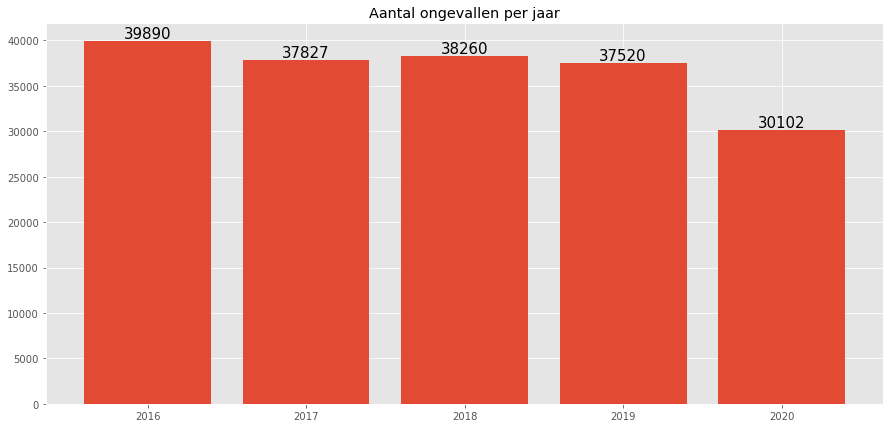

In [10]:
jaren = []
jaren_aantal = []

for row in df_all_acc.groupBy('YEAR').count().orderBy('YEAR').collect():
    jaren.append(row['YEAR'])
    jaren_aantal.append(row['count'])

plt.figure(figsize=(15, 7))
plt.style.use("ggplot")
plt.title('Aantal ongevallen per jaar')
plt.bar(jaren, jaren_aantal)

for index,data in enumerate(jaren_aantal):
    plt.text(index, data,
        s=f"{data}",color = 'black',fontsize=15, va='bottom', ha='center')

plt.show()

**Interessant inzicht** <br />
We zien duidelijk het effect van de lockdowns in het jaar 2020: er zijn een +- 8000 minder ongevallen dan gemiddeld.

In [11]:
def get_map(year):
    i = folium.Map(location=[50.641111, 4.668056], zoom_start=8)
    #.filter(df_inh_municipality_coords.INHABITANTS > 18000)
    data4 = df_inh_municipality_coords.filter(df_inh_municipality_coords.CD_YEAR == year).select('TX_MUNTY_DESCR_NL', 'XCoord', 'YCoord', 'INHABITANTS').collect()

    layer1 = folium.FeatureGroup(name='Inwoners').add_to(i)
    layer2 = folium.FeatureGroup(name='Ongevallen').add_to(i)


    for row in data4:
        folium.Circle(
            location=[row['XCoord'], row['YCoord']],
            radius=row['INHABITANTS']/50,
            color="#3186cc",
            popup=row['TX_MUNTY_DESCR_NL'] + '\n' + str(row['INHABITANTS']) + ' inwoners',
            name='test',
            weight=3
        ).add_to(layer1)


    data3 = df_accidents_municipality_coords.filter(df_accidents_municipality_coords.YEAR == year).select('TX_MUNTY_DESCR_NL', 'XCoord', 'YCoord', 'count').collect()

    for row in data3:
        folium.Circle(
            location=[row['XCoord'], row['YCoord']],
            radius=row['count']*5,
            color="#FF0000",
            popup=row['TX_MUNTY_DESCR_NL'] + '\n' + str(row['count']) + ' ongevallen',
            weight=3
        ).add_to(layer2)

    folium.LayerControl().add_to(i)
    
    loc = 'Ongevallen en inwonersaantallen (' + str(year) + ')'
    title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)   
    
    i.get_root().html.add_child(folium.Element(title_html))
    
    return i

map_2016 = get_map(2016)
map_2017 = get_map(2017)
map_2018 = get_map(2018)
map_2019 = get_map(2019)
map_2020 = get_map(2020)

def map_selector(year):
    if year == 2016:
        return map_2016
    elif year == 2017:
        return map_2017
    elif year == 2018:
        return map_2018
    elif year == 2019:
        return map_2019
    elif year == 2020:
        return map_2020
    
interact(map_selector, year=widgets.IntSlider(value=2020,
    min=2016,
    max=2020,
    step=1,
    description='Jaar:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'));

interactive(children=(IntSlider(value=2020, description='Jaar:', max=2020, min=2016), Output()), _dom_classes=…

In [12]:
data_ernst = types_accidents_year_percentages.collect()
data2 = df_all_acc.groupBy("YEAR", "MONTH", "MONTH_NUMBER").count().orderBy(col("MONTH_NUMBER").cast("int")).collect()
data4 = df_all_acc.groupBy("CD_DAY_OF_WEEK", "TX_DAY_OF_WEEK_DESCR_NL", "YEAR").count().orderBy(col("CD_DAY_OF_WEEK").cast("int")).collect()
data5 = df_all_acc.filter(col('DT_HOUR') != '-1').groupBy("DT_HOUR", "YEAR").count().orderBy(col("DT_HOUR").cast("int")).collect()

def f(x):
    # Plot per month
    maanden = []
    aantal = []
    for row in data2:
        if row['YEAR'] == str(x):
            maanden.append(row['MONTH'])
            aantal.append(row['count'])
        
    plt.figure(figsize=(15, 7))
    plt.style.use("ggplot")
    plt.title('Ongevallen per maand ({jaar})'.format(jaar=str(x)))
    maanden.reverse()
    aantal.reverse()
    plt.barh(maanden, aantal)
    for index,data in enumerate(aantal):
        plt.text(data, index,
                 s=f"{data}",color = 'black',fontsize=15, va='center', ha='left')
    plt.show()
    
    # Plot per day 
    dagen = []
    aantal = []
       
    for row in data4:
        if row['YEAR'] == str(x):
            dagen.append(row['TX_DAY_OF_WEEK_DESCR_NL'].capitalize())
            aantal.append(row['count'])
       
    plt.figure(figsize=(15, 4))
    plt.style.use("ggplot")
    plt.title('Ongevallen per weekdag ({jaar})'.format(jaar=str(x)))
    
    plt.bar(dagen, aantal) 
    for index,data in enumerate(aantal):
        plt.text(index, data,
                 s=f"{data}",color = 'black',fontsize=15, va='bottom', ha='center')
    plt.show()
    
    # Plot per hour 
    uren = []
    aantal = []
       
    for row in data5:
        if row['YEAR'] == str(x):
            uren.append(row['DT_HOUR'].capitalize())
            aantal.append(row['count'])
       
    plt.figure(figsize=(15, 5))
    plt.style.use("ggplot")
    plt.title('Ongevallen per uur ({jaar})'.format(jaar=str(x)))
    
    plt.bar(uren, aantal) 
    for index,data in enumerate(aantal):
        plt.text(index, data,
                 s=f"{data}",color = 'black',fontsize=15, va='bottom', ha='center')
    plt.show()
    
    # Plot per severity
    ernst_data = []
    
    for row in data_ernst:
        if row['YEAR'] == str(x): 
            ernst_data.append(row[3])
            ernst_data.append(row[5])
            ernst_data.append(row[6])
            ernst_data.append(row[2])

    
    plt.style.use("default")
    labels = 'Ongeval met ernstig gewonden', 'Ongeval met overlijden binnen de 30 dagen','Dodelijk ongeval', 'Ongeval met lichtgewonden'
    colors=['#fd8c00','#dc0000','#780000','#00ac46']
    sizes = ernst_data
    explode = (0.1, 0.3, 0.5, 0.0)
    fig1, ax1 = plt.subplots()
    
    bbox=dict(facecolor='grey', edgecolor='grey', boxstyle='round', alpha=0.7)
    
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%', colors=colors, textprops={'color':'white', 'weight': 'bold','bbox': bbox})
    ax1.axis('equal')
    plt.title('Verdeling ongevallen op basis van ernst ({jaar})'.format(jaar=str(x)))
    plt.show()
    
    return 

interact(f, x=widgets.IntSlider(value=2020,
    min=2016,
    max=2020,
    step=1,
    description='Jaar:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'));



interactive(children=(IntSlider(value=2020, description='Jaar:', max=2020, min=2016), Output()), _dom_classes=…

**Interessante inzichten** <br />
Op de grafiek ongevallen per maand is voor het jaar 2020 duidelijk het effect van de eerste lockdown te zien: er zijn buidende veel minder ongevallen in maart en april.

De meeste ongevallen gebeuren op vrijdag. In het weekend gebeuren minder ongevallen dan op weekdagen.

Ook is duidelijk het effect van de ochtendspits zichtbaar door een sterke toename rond 8h en 9h. Vanaf 10h neemt het aantal ongevallen geleidelijk aan toe om zijn piek te bereiken tijdens de avondspits rond 17h en 18h.

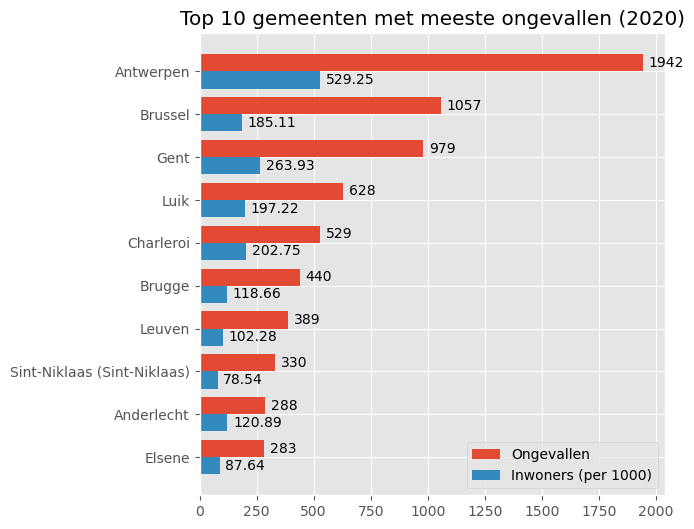

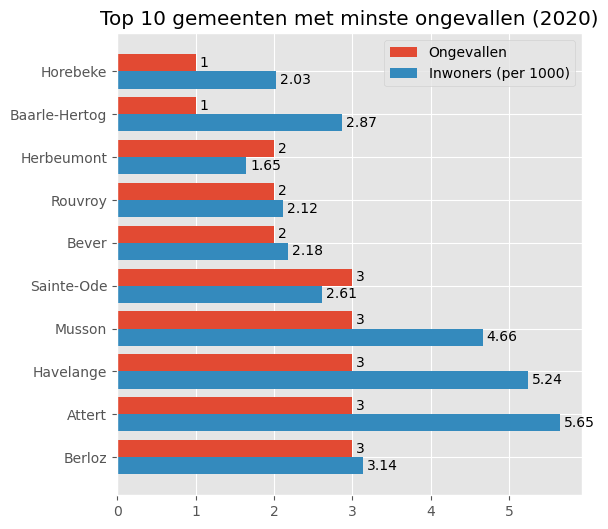

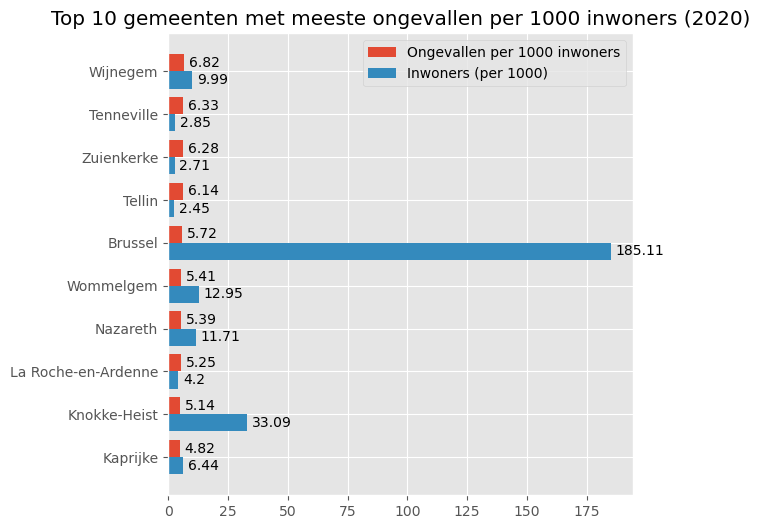

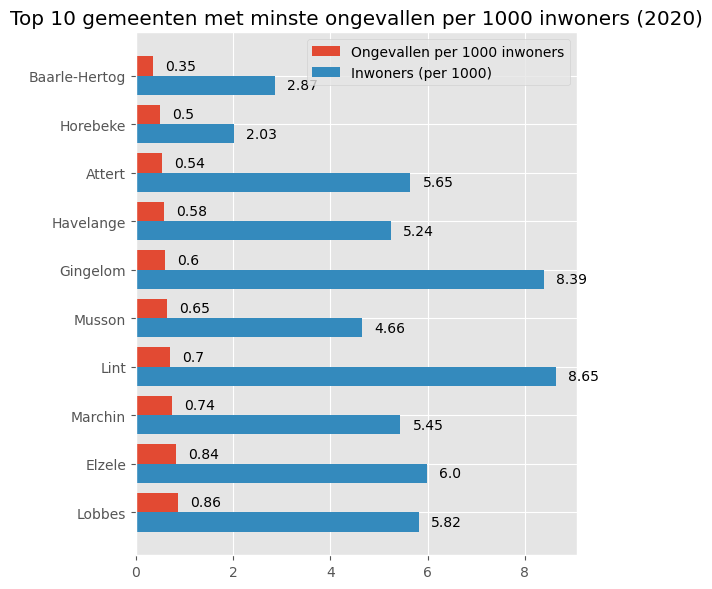

In [13]:
### GRAPH 1 ### GRAPH 1 ### GRAPH 1 ### GRAPH 1

top_10_meeste_ongevallen = df_accidents_municipality_inhabitants.orderBy(col('count').desc()).filter(col('YEAR') == '2020').take(10)

steden = []
ongevallen = []
inwoners = []

for row in top_10_meeste_ongevallen:
    steden.append(row['TX_MUNTY_DESCR_NL'])
    ongevallen.append(row['count'])
    inwoners.append(row['INHABITANTS'] / 1000)

plt.figure(figsize=(6, 6))
plt.style.use("ggplot")
    
    
# set width of bars
barWidth = 0.4
 
# Set position of bar on X axis
r1 = np.arange(len(steden))
r2 = [x + barWidth for x in r1]
 
# Make the plot
bars = plt.barh(r1, ongevallen, barWidth, label='Ongevallen')
bars2 = plt.barh(r2, inwoners, barWidth, label='Inwoners (per 1000)')

for bar in bars:
    label_y_pos = bar.get_y() + bar.get_height() / 2
    label_x_pos = bar.get_width()
    plt.text(label_x_pos + 25, label_y_pos, s=label_x_pos, va='center', ha='left')
    
for bar in bars2:
    label_y_pos = bar.get_y() + bar.get_height() / 2
    label_x_pos = bar.get_width()
    plt.text(label_x_pos + 25, label_y_pos, s=np.true_divide(np.ceil(label_x_pos * 10**2), 10**2), va='center', ha='left')

# Add xticks on the middle of the group bars
plt.yticks([r + (barWidth/2) for r in range(len(steden))], steden)
 
# Create legend & Show graphic
plt.title('Top 10 gemeenten met meeste ongevallen (2020)')
plt.legend()
plt.gca().invert_yaxis()
plt.show()

### GRAPH 2 ### GRAPH 2 ### GRAPH 2 ### GRAPH 2

top_10_minste_ongevallen = df_accidents_municipality_inhabitants.orderBy(col('count').asc()).filter(col('YEAR') == '2020').take(10)

steden = []
ongevallen = []
inwoners = []

for row in top_10_minste_ongevallen:
    steden.append(row['TX_MUNTY_DESCR_NL'])
    ongevallen.append(row['count'])
    inwoners.append(row['INHABITANTS'] / 1000)

plt.figure(figsize=(6, 6))
plt.style.use("ggplot")
    
    
# set width of bars
barWidth = 0.4
 
# Set position of bar on X axis
r1 = np.arange(len(steden))
r2 = [x + barWidth for x in r1]
 
# Make the plot
bars = plt.barh(r1, ongevallen, barWidth, label='Ongevallen')
bars2 = plt.barh(r2, inwoners, barWidth, label='Inwoners (per 1000)')

for bar in bars:
    label_y_pos = bar.get_y() + bar.get_height() / 2
    label_x_pos = bar.get_width()
    plt.text(label_x_pos + 0.05, label_y_pos, s=label_x_pos, va='center', ha='left')
    
for bar in bars2:
    label_y_pos = bar.get_y() + bar.get_height() / 2
    label_x_pos = bar.get_width()
    plt.text(label_x_pos + 0.05, label_y_pos, s=np.true_divide(np.ceil(label_x_pos * 10**2), 10**2), va='center', ha='left')

# Add xticks on the middle of the group bars
plt.yticks([r + (barWidth/2) for r in range(len(steden))], steden)
 
# Create legend & Show graphic
plt.title('Top 10 gemeenten met minste ongevallen (2020)')
plt.legend()
plt.gca().invert_yaxis()
plt.show()

### GRAPH 3 ### GRAPH 3 ### GRAPH 3 ### GRAPH 3

top_10_meeste_ongevallen_per_1000 = df_accidents_municipality_inhabitants.orderBy(col('APTI').desc()).filter(col('YEAR') == '2020').take(10)

steden = []
ongevallen_per_1000_inwoners = []
inwoners = []

for row in top_10_meeste_ongevallen_per_1000:
    steden.append(row['TX_MUNTY_DESCR_NL'])
    ongevallen_per_1000_inwoners.append(row['APTI'])
    inwoners.append(row['INHABITANTS'] / 1000)

plt.figure(figsize=(6, 6))
plt.style.use("ggplot")
    
    
# set width of bars
barWidth = 0.4
 
# Set position of bar on X axis
r1 = np.arange(len(steden))
r2 = [x + barWidth for x in r1]
 
# Make the plot
bars = plt.barh(r1, ongevallen_per_1000_inwoners, barWidth, label='Ongevallen per 1000 inwoners')
bars2 = plt.barh(r2, inwoners, barWidth, label='Inwoners (per 1000)')

for bar in bars:
    label_y_pos = bar.get_y() + bar.get_height() / 2
    label_x_pos = bar.get_width()
    plt.text(label_x_pos + 2, label_y_pos, s=np.true_divide(np.ceil(label_x_pos * 10**2), 10**2), va='center')
    
for bar in bars2:
    label_y_pos = bar.get_y() + bar.get_height() / 2
    label_x_pos = bar.get_width()
    plt.text(label_x_pos + 2, label_y_pos, s=np.true_divide(np.ceil(label_x_pos * 10**2), 10**2), va='center')

# Add xticks on the middle of the group bars
plt.yticks([r + (barWidth/2) for r in range(len(steden))], steden)
 
# Create legend & Show graphic
plt.title('Top 10 gemeenten met meeste ongevallen per 1000 inwoners (2020)')
plt.legend()
plt.gca().invert_yaxis()
plt.show()    

### GRAPH 4 ### GRAPH 4 ### GRAPH 4 ### GRAPH 4

top_10_minste_ongevallen_per_1000 = df_accidents_municipality_inhabitants.orderBy(col('APTI').asc()).filter(col('YEAR') == '2020').take(10)

steden = []
ongevallen_per_1000_inwoners = []
inwoners = []

for row in top_10_minste_ongevallen_per_1000:
    steden.append(row['TX_MUNTY_DESCR_NL'])
    ongevallen_per_1000_inwoners.append(row['APTI'])
    inwoners.append(row['INHABITANTS'] / 1000)

plt.figure(figsize=(6, 6))
plt.style.use("ggplot")
    
    
# set width of bars
barWidth = 0.4
 
# Set position of bar on X axis
r1 = np.arange(len(steden))
r2 = [x + barWidth for x in r1]
 
# Make the plot
bars = plt.barh(r1, ongevallen_per_1000_inwoners, barWidth, label='Ongevallen per 1000 inwoners')
bars2 = plt.barh(r2, inwoners, barWidth, label='Inwoners (per 1000)')

for bar in bars:
    label_y_pos = bar.get_y() + bar.get_height() / 2
    label_x_pos = bar.get_width()
    plt.text(label_x_pos + 0.25, label_y_pos, s=np.true_divide(np.ceil(label_x_pos * 10**2), 10**2), va='center')
    
for bar in bars2:
    label_y_pos = bar.get_y() + bar.get_height() / 2
    label_x_pos = bar.get_width()
    plt.text(label_x_pos + 0.25, label_y_pos, s=np.true_divide(np.ceil(label_x_pos * 10**2), 10**2), va='center')
    
# Add xticks on the middle of the group bars
plt.yticks([r + (barWidth/2) for r in range(len(steden))], steden)
 
# Create legend & Show graphic
plt.title('Top 10 gemeenten met minste ongevallen per 1000 inwoners (2020)')
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()    

In [27]:
totaal_ongevallen = df_accidents_municipality_inhabitants.groupBy('YEAR').agg(sf.sum('count').alias('ONGEVALLEN'))
totaal_inwoners = df_accidents_municipality_inhabitants.groupBy('YEAR').agg(sf.sum('INHABITANTS').alias('INWONERS'))
totaal = totaal_ongevallen.join(totaal_inwoners, 'YEAR')

In [33]:
totaal.withColumn('ONGEVALLEN PER 1000 INWONERS', col('ONGEVALLEN') / col('INWONERS') * 1000).orderBy('YEAR').show()

+----+----------+--------+----------------------------+
|YEAR|ONGEVALLEN|INWONERS|ONGEVALLEN PER 1000 INWONERS|
+----+----------+--------+----------------------------+
|2016|     39890|11267821|           3.540169834078834|
|2017|     37827|11320950|          3.3413273621030037|
|2018|     38260|11372738|          3.3641854758282483|
|2019|     37520|11431323|          3.2822097669709795|
|2020|     30102|11488062|           2.620285301385038|
+----+----------+--------+----------------------------+



## Besluit
Er zijn redelijk wat interessante inzichten die we uit de datasets kunnen halen. We zien ook dat in het algemeen, het aantal inwoners in een gemeente een invloed heeft op het aantal ongevallen. Per duizend inwoners gebeuren er zo gemiddeld gezien tussen de 2.5 en 3.5 ongevallen per jaar.

Maar zoals op bovenstaande grafieken geillustreerd, kunnen ook gemeenten met weinig inwoners een hoog aantal ongevallen per duizend inwoners hebben.